# 1 - IMPORTS

## 1.1 - Libraries

*Load required libraries for the project*

In [2]:
!pip install --upgrade -q pylangacq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 KB 5.5 MB/s eta 0:00:00


In [38]:
!pip install  feature_engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.0/290.0 KB 9.5 MB/s eta 0:00:00


In [39]:
# OS
import os
from   pathlib import Path

# import required libraries
from google.colab import files

# date
from datetime import datetime

# data manipulation
import re
import numpy      as     np
import pandas     as     pd

# plot and images
import seaborn              as sns
import matplotlib.pyplot    as plt

# NLP 
import pylangacq
# from nltk.stem import WordNetLemmatizer
# from nltk import pos_tag

# Generating Synthetic data
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC
from imblearn.under_sampling import NearMiss, TomekLinks
from feature_engine.selection import RecursiveFeatureElimination
# modelling
from sklearn.model_selection import train_test_split, LeavePOut, StratifiedKFold, learning_curve, cross_validate
from sklearn.dummy           import DummyClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics         import log_loss, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from lightgbm import LGBMClassifier

# explainability
#import shap

In [4]:
# e.g.     
# set cientific notation for pandas
pd.set_option(
    "display.float_format", "{:,.3f}".format 
)

## 1.4 - Constants 

In [5]:
# define seed and random states
seed = 0

# 2 - DATA EXTRACTION

## 2.1 - Data dictionary

*Describe the meaning of every column of the dataset*

## 2.2 - Data Loading

*Load data from required files*

In [6]:
# # upload data
from google.colab import files
uploaded = files.upload()

Saving Nadig.zip to Nadig.zip
Saving Eigsti.zip to Eigsti.zip


In [7]:
def extract_features(pylangacq_zip_path, chi_part_tag="CHI", non_child_part_tags=None):

    # extract info from .zip file
    pylang_data = pylangacq.read_chat( pylangacq_zip_path )

    # print number of transcriptions
    print(f"Extracting features from {pylang_data.n_files()} transcriptions")

    # create an empty dataframe 
    df_extraction = pd.DataFrame()

    # iterate over transcripts
    for idx, i in enumerate(pylang_data):
        # create a dictionary for extracted features
        features_dict = {}
        
        ####### add values to dataframe #######
        # add ASD label
        features_dict["ASD"] = i.headers()[0]["Participants"][chi_part_tag]["group"]
        
        # check if non_child_part_tags was input
        if not non_child_part_tags is None:
            # check non_child_part_tags type
            if not isinstance(non_child_part_tags, list):
                # error message
                raise TypeError("non_child_part_tags param must be a list.")

        # no non_child_part_tags was input
        else:
            # get non-child participants tags
            non_child_part_tags = list(i.headers()[0]["Participants"].keys())
            # remove child tag
            non_child_part_tags.remove(chi_part_tag)

        # print report
        print(f'File number {idx+1} has the following non-child participants: {", ".join(non_child_part_tags)}')

        # get mlu
        child_mlu = i.mlu(participant=chi_part_tag)[0]    
        # get mean mlu for non-child participants
        mean_mlu_non_child = np.mean([i.mlu(participant=non_child)[0] 
                                    for non_child 
                                    in non_child_part_tags])
        # check misleading information
        if mean_mlu_non_child == 0:
            # print report
            print(f'File number {idx+1} has mean_mlu_non_child = zero. Does this make sense?')
        # avoid error by zero division    
        mean_mlu_non_child = (mean_mlu_non_child if mean_mlu_non_child != 0 else 0.1)
        # add child mlu
        features_dict["child_mlu"] = child_mlu
        # get percentage of child mlu / non-child mean mlu
        features_dict["percent_child_parents_mlu"] = child_mlu / mean_mlu_non_child

        # get mluw
        child_mluw = i.mluw(participant=chi_part_tag)[0]
        # get mean mluw for non-child participants
        mean_mluw_non_child = np.mean([i.mluw(participant=non_child)[0] 
                                    for non_child 
                                    in non_child_part_tags])
        # check misleading information
        if mean_mluw_non_child == 0:
            # print report
            print(f'-------> File number {idx+1} has mean_mluw_non_child = zero. Does this make sense? <-------')
        # avoid error by zero division    
        mean_mluw_non_child = (mean_mluw_non_child if mean_mluw_non_child != 0 else 0.1)
        # add child mluw
        features_dict["child_mluw"] = child_mluw
        # get percentage of child mluw / non-child mean mluw
        features_dict["percent_child_parents_mluw"] = child_mluw / mean_mluw_non_child

        # get ttr
        child_ttr = i.ttr(participant=chi_part_tag)[0]
        # get mean ttr for non-child participants
        mean_ttr_non_child = np.mean([i.ttr(participant=non_child)[0] 
                                    for non_child 
                                    in non_child_part_tags])
        # check misleading information
        if mean_ttr_non_child == 0:
            # print report
            print(f'-------> File number {idx+1} has mean_ttr_non_child = zero. Does this make sense? <-------')
        # avoid error by zero division    
        mean_ttr_non_child = (mean_ttr_non_child if mean_ttr_non_child != 0 else 0.1)
        # add child ttr
        features_dict["child_ttr"] = child_ttr
        # get percentage of child ttr / non-child mean ttr
        features_dict["percent_child_parents_ttr"] = child_ttr / mean_ttr_non_child

        # get ipsyn
        child_ipsyn = i.ipsyn(participant=chi_part_tag)[0]
        # get mean ipsyn for non-child participants
        mean_ipsyn_non_child = np.mean([i.ipsyn(participant=non_child)[0] 
                                        for non_child 
                                        in non_child_part_tags])
        # check misleading information
        if mean_ipsyn_non_child == 0:
            # print report
            print(f'-------> File number {idx+1} has mean_ipsyn_non_child = zero. Does this make sense? <-------')
        # avoid error by zero division    
        mean_ipsyn_non_child = (mean_ipsyn_non_child if mean_ipsyn_non_child != 0 else 0.1)
        # add child ipsyn
        features_dict["child_ipsyn"] = child_ipsyn
        # get percentage of child ipsyn / non-child mean ipsyn
        features_dict["percent_child_parents_ipsyn"] = child_ipsyn / mean_ipsyn_non_child

        # get number of words
        features_dict["child_num_words"] = len(i.words(participants=chi_part_tag))
        # get percentage of child words / parent words
        features_dict["perct_child_parents_words"] = len(i.words(participants=chi_part_tag)) / len(i.words(exclude=(chi_part_tag)))
        # get number of unique words
        features_dict["child_num_unique_words"] = len(set(i.words(participants=chi_part_tag)))
        # get percentage of child unique words / parent unique words
        features_dict["perct_child_parents_unique_words"] = len(set(i.words(participants=chi_part_tag))) / len(set(i.words(exclude=(chi_part_tag))))
        # get number of tokens
        features_dict["child_num_tokens"] = len(i.tokens(participants=chi_part_tag))
        # get percentage of child tokens / parent tokens
        features_dict["perct_child_parents_tokens"] = len(i.tokens(participants=chi_part_tag)) / len(i.tokens(exclude=(chi_part_tag)))
        # get number of utterances or turn 
        features_dict["child_utterances"] = len(i.utterances(participants=chi_part_tag))
        # get percentage of child utterances / parent utterances
        features_dict["perct_child_parents_utterances"] = len(i.utterances(participants=chi_part_tag)) / len(i.utterances(exclude=chi_part_tag))
        #MlT
        features_dict["MLT"] = ((len(i.utterances(participants=chi_part_tag)) / (len(i.utterances(participants=chi_part_tag)) + len(i.utterances(exclude=chi_part_tag)))))  /((len(i.utterances(exclude=chi_part_tag)) / (len(i.utterances(participants=chi_part_tag)) + len(i.utterances(exclude=chi_part_tag)))))                         
        #get age feature
        features_dict["age par month"] = (i.ages(months=True))

        #get sex
        features_dict["sex"] = i.headers()[0]["Participants"][chi_part_tag]["sex"]
        #get corpus
        features_dict["corpus"] = i.headers()[0]["Participants"][chi_part_tag]["corpus"]
        #get types
        features_dict["types"] = i.headers()[0]["Types"]
        #get ses of child
        features_dict["chi_ses"] = i.headers()[0]["Participants"][chi_part_tag]["ses"]
        #get the education of mother
        #features_dict["mother_edu"] = i.headers()[0]['Participants']['MOT']['education'] 
        # get part of speech (POS) for every token in child utterances
        child_pos = [token.pos for token in i.tokens(participants=chi_part_tag)]   
        # get number of tokens
        num_tokens = features_dict["child_num_tokens"]
        # sanity check
        assert num_tokens == len(child_pos), "Missing POS tags!"
        
        # get values counts for pos
        pos_value_counts = pd.Series(child_pos).value_counts(dropna=False)
        # convert to dict
        pos_value_counts_dict = pos_value_counts.to_dict()
        # add pos_ prefix before pos tags
        pos_value_counts_dict = { ("pos_percent_" + str(k)): (v / num_tokens) for k, v in pos_value_counts_dict.items() }
        # sanity check 
        assert abs(1 - sum([*pos_value_counts_dict.values()])) < 0.01, "Missing POS tags!"
        
        # add pos_value_counts_dict to features_dict
        features_dict = {**features_dict, **pos_value_counts_dict}
        # create a pandas dataframe from features dict
        df_features = pd.DataFrame(data=features_dict, index=[0])
        # concatenate features dataframe with extraction dataframe
        df_extraction = pd.concat(objs=[df_extraction, df_features], ignore_index=True)

    # print report
    print(f"{df_extraction.shape[1]-1} features extracted from {df_extraction.shape[0]}")

    return df_extraction

In [30]:
df_nadig = extract_features("/content/Nadig.zip")
df_eigsti = extract_features("/content/Eigsti.zip")


Extracting features from 38 transcriptions
File number 1 has the following non-child participants: MOT
File number 2 has the following non-child participants: MOT
File number 3 has the following non-child participants: MOT
File number 4 has the following non-child participants: MOT
File number 5 has the following non-child participants: MOT
File number 6 has the following non-child participants: MOT
File number 7 has the following non-child participants: MOT
File number 8 has the following non-child participants: MOT
File number 9 has the following non-child participants: MOT
File number 10 has the following non-child participants: MOT
File number 11 has the following non-child participants: MOT
File number 12 has the following non-child participants: MOT
File number 12 has mean_mlu_non_child = zero. Does this make sense?
-------> File number 12 has mean_mluw_non_child = zero. Does this make sense? <-------
-------> File number 12 has mean_ttr_non_child = zero. Does this make sense? <-

In [14]:
df_nadig=pd.get_dummies(df_nadig,drop_first=True)

In [9]:
df_nadig.isnull().sum()

ASD                            0
child_mlu                      0
percent_child_parents_mlu      0
child_mluw                     0
percent_child_parents_mluw     0
                              ..
pos_percent_chi               33
pos_percent_pro:poss          34
pos_percent_n:let             37
pos_percent_bab               36
pos_percent_sing              37
Length: 76, dtype: int64

# 3 - DATA DESCRIPTION

## 3.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

## 3.2 - Column Names

*Search for misleading or error-prone column names*

In [23]:
# check column names
df_nadig.columns

Index(['ASD', 'child_mlu', 'percent_child_parents_mlu', 'child_mluw',
       'percent_child_parents_mluw', 'child_ttr', 'percent_child_parents_ttr',
       'child_ipsyn', 'percent_child_parents_ipsyn', 'child_num_words',
       'perct_child_parents_words', 'child_num_unique_words',
       'perct_child_parents_unique_words', 'child_num_tokens',
       'perct_child_parents_tokens', 'child_utterances',
       'perct_child_parents_utterances', 'MLT', 'age par month', 'sex',
       'corpus', 'types', 'chi_ses', 'pos_percent_co', 'pos_percent_.',
       'pos_percent_nan', 'pos_percent_n', 'pos_percent_v', 'pos_percent_!',
       'pos_percent_pro:sub', 'pos_percent_adv', 'pos_percent_neg',
       'pos_percent_qn', 'pos_percent_?', 'pos_percent_prep',
       'pos_percent_mod', 'pos_percent_pro:per', 'pos_percent_pro:dem',
       'pos_percent_adj', 'pos_percent_pro:rel', 'pos_percent_det:art',
       'pos_percent_pro:int', 'pos_percent_aux', 'pos_percent_cop',
       'pos_percent_+...', 'pos_pe

## 3.3 - Data Types

*Check if data types on dataframe makes sense according to database information*

In [24]:
# check data types
df_nadig.dtypes

ASD                            object
child_mlu                     float64
percent_child_parents_mlu     float64
child_mluw                    float64
percent_child_parents_mluw    float64
                               ...   
pos_percent_chi               float64
pos_percent_pro:poss          float64
pos_percent_n:let             float64
pos_percent_bab               float64
pos_percent_sing              float64
Length: 76, dtype: object

## 3.4 - Check Duplicated Rows

*Inspect duplicated rows (based on dataframe granularity) and handle them properly*

In [25]:
# TO-DO
df_nadig.duplicated().sum()
#df_eigsti.duplicated().sum()

0

## 3.5 - Check Missing Values

*Inspect number and percentage of missing value per column to decide what to do with them*

In [ ]:
# check NAn
df_nadig.isna().sum()
#df_eigsti.isna().sum()

## 3.6 - Handle Missing Values

In [43]:
# fill missing values with 0
df_nadig = df_nadig.fillna(value=0)
df_eigsti=df_eigsti.fillna(value=0)

*Handle missing value for columns*

# 4-Data Preparation

In [32]:
df_nadig.ASD.value_counts()

TYP    25
ASD    13
Name: ASD, dtype: int64

In [31]:
df_eigsti.ASD.value_counts()

ASD    16
TD     16
DD     16
Name: ASD, dtype: int64

In [34]:
df_nadig['ASD']= df_nadig['ASD'].map({"ASD": 1,'TYP':0})
df_eigsti['ASD']= df_eigsti['ASD'].map({"ASD": 1,'TD':0,'DD':2})

In [35]:
df_nadig=pd.get_dummies(df_nadig,drop_first=True)
df_eigsti=pd.get_dummies(df_eigsti,drop_first=True)

In [47]:
all_data=pd.concat([df_nadig,df_eigsti],ignore_index=True)

In [ ]:
all_data.duplicated().sum()

# 5-Features importance with RFE

In [56]:
# define ratio of test split ratio 
test_ratio = 0.2 
seed=0
# Train-Test split for the whole dataset
# X: attributes
# y: labels
def feat_selc(df):
 X = df.drop(columns=["ASD"])
 y = df["ASD"]
 X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_ratio, random_state=seed, 
                                                    shuffle=True, stratify=y)

# reset index after train test split
 X_train = X_train.reset_index(drop=True)
 y_train = y_train.reset_index(drop=True)
 X_test = X_test.reset_index(drop=True)
 y_test = y_test.reset_index(drop=True)
  # define scaler object
 ss = StandardScaler(copy=True, with_mean=True, with_std=True)

# fit to data and get scaled dataframe
 X_train_scaled = pd.DataFrame(data=ss.fit_transform(X_train), columns=X_train.columns)
 clf = RandomForestClassifier(n_estimators=100, max_depth=10)

#===========================================================================
# perform  Feature Elimination (RFE)
#===========================================================================


 ref=RecursiveFeatureElimination(estimator=clf,scoring='f1',cv=5)
##n_features_to_select = 10
#rfe = RFE(regressor, n_features_to_select=n_features_to_select)
 ref.fit(X_train_scaled, y_train)
 
 # create a dataframe with feature importances
 df_f_importance = pd.DataFrame(data=ref.feature_importances_, index=X_train.columns)
# reset index and rename column
 df_f_importance = df_f_importance.reset_index()
 df_f_importance = df_f_importance.rename(columns={"index":"features", 0:"feature_importance"})
# define column names
 df_f_importance = df_f_importance.sort_values(by="feature_importance", ascending=False)

# define figure size
 fig = plt.figure(figsize=(10, 15))

# plot
 sns.barplot(data=df_f_importance, x="feature_importance", y="features")
# define details
 plt.title("Feature importance according to RFE", loc="center")
 plt.axvline(0.025, linestyle=":", color="black")
 plt.show()

#Features importance  in nadig

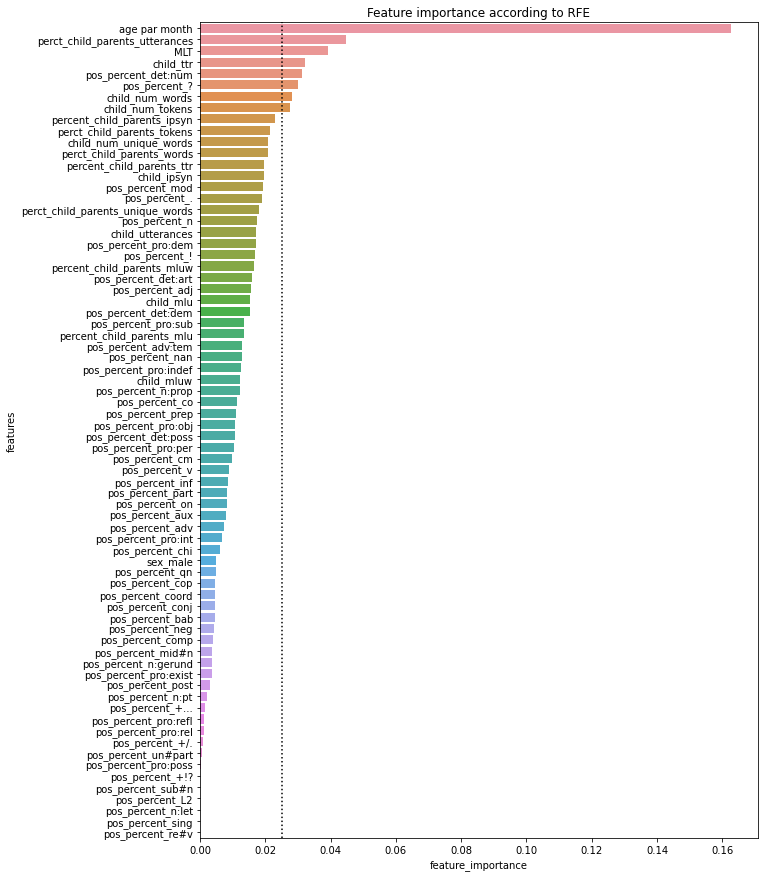

In [53]:
feat_selc(df_nadig)

# Features impartance in eigsti

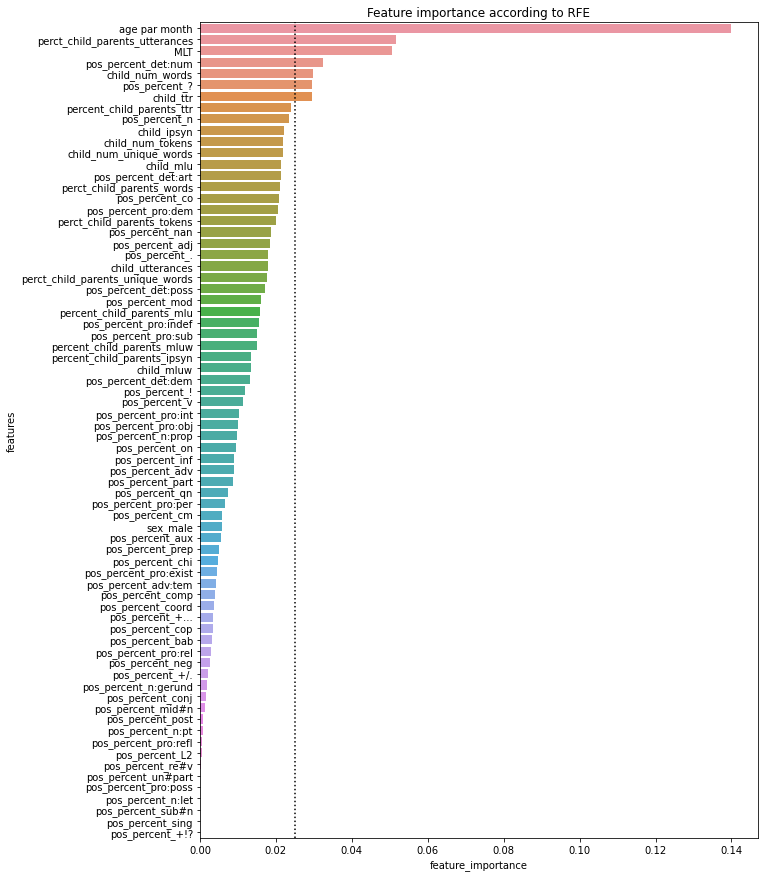

In [54]:
feat_selc(df_eigsti)

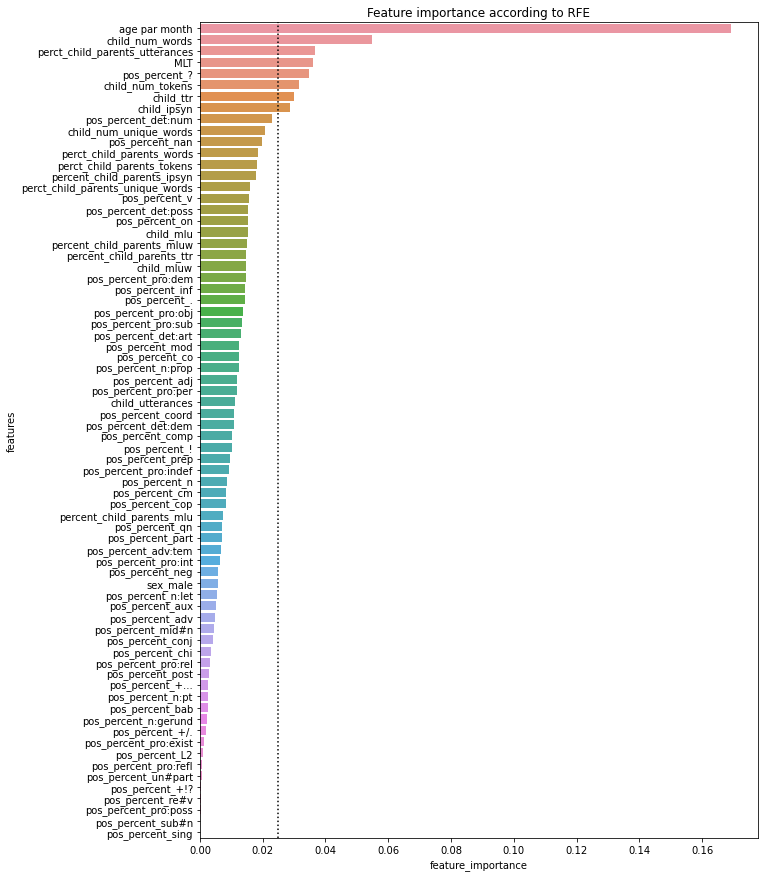

In [57]:
feat_selc(all_data)

# 7 - Synthetic Data

*Do we need to create synthetic data?*

*Is it possible to create synthetic data for this problem?*

*What are the pros and cons of synthetic data?*

*Techniques*:
- oversampling
- undersampling
- SMOTE
- model loss function weighting

In [23]:
# TO-do
from collections import Counter
SMOTE = SMOTE()

# fit and apply the transform
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)

# summarize class distribution
print("After oversampling: ",Counter(y_train_SMOTE))

After oversampling:  Counter({1: 20, 0: 20})
